# Relative Entropy Inverse Reinforcement Learning (RelEnt IRL)

Relative Entropy Inverse Reinforcement Learning is a primitive model-free IRL method - in which you don't need to know the system dynamics -, because you can run this method, **even when the transition probability is unknown**. (Usually, to know the transition probability is not the case in many robotic applications.)

Relative Entropy IRL method is inspired by Relative Entropy Policy Search (REPS).<br>
Assuming that the expert is optimal, this method learns a reward function. And you can then use it to recover the expert's generalized policy.

As you can see below, this method requires not only expert demonstrations, but also requires non-expert demonstrations by an arbitrary policy, for performing importance sampling.

*(back to [index](https://github.com/tsmatz/imitation-learning-tutorials/))*

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
get_ipython().system('pip install torch numpy')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-RL-Gym/Imitation-learning-Gridworld.git
! git pull origin master
# ! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 141 (delta 90), reused 76 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 1.45 MiB | 12.60 MiB/s, done.
Resolving deltas: 100% (90/90), done.
From https://github.com/tsmatz/imitation-learning-tutorials
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin

## Overview of Relative Entropy Inverse Reinforcement Learning method

First of all, let's briefly follow Relative Entropy IRL along with the original paper [[A Boularias et al., 2011](https://proceedings.mlr.press/v15/boularias11a/boularias11a.pdf)].

Suppose $P(\cdot)$ and $Q(\cdot)$ are probability distributions.<br>
The following relative entropy (or KL-divergence) $\verb|Rel|(P || Q)$ is a distance of distributions between $P$ and $Q$, in which relative entropy always satisfies $\verb|Rel|(P || Q) \geq 0$ with equality if, and only if, $P(\tau) = Q(\tau)$

$\displaystyle \verb|Rel|(P || Q) \coloneqq \sum_{\tau} P(\tau) \ln{\frac{P(\tau)}{Q(\tau)}}$

> Note : The relative entropy (KL-divergence) is $\displaystyle \int P(\tau) \ln{\frac{P(\tau)}{Q(\tau)}} d\tau$ in continuous sapce, and $\displaystyle \sum_{\tau} P(\tau) \ln{\frac{P(\tau)}{Q(\tau)}} $ in discrete space.<br>
> In this example, we assume it's discrete space.

Assuming that $Q(\cdot)$ is the distribution of expert policy (baseline policy) on trajectories $\mathcal{T}$, Relative Entropy IRL is a method to find the distribution $P(\cdot)$ to minimize :

$\displaystyle \sum_{\tau \in \mathcal{T}} P(\tau) \ln{\frac{P(\tau)}{Q(\tau)}} $

subject to the following constraints. :

- $ \left| \sum_{\tau \in \mathcal{T}} P(\tau) f_i^{\tau} - \hat{f}_i \right| \leq \epsilon_i \;\;\; \forall i \in \{1, \ldots ,k\}$
- $ \sum_{\tau \in \mathcal{T}} P(\tau) = 1 $
- $ P(\tau) \geq 0 \;\;\; \forall \tau \in \mathcal{T} $

where $f_i^{\tau}$ is the $i$-th element in the feature vector of the trajectory $\tau$, and $\hat{f}_i$ is the $i$-th element in the expected feature vector which is induced by the expert demonstrations.

The first constraint is the feature expectation matching constraint. (See [here](./03_maxent_irl.ipynb) for the feature expectation matching in IRL.)<br>
When $\gamma$ is a discount, $f_i^{\tau} = \sum_t \gamma^t f_i(s_t)$, where $t$ is time-step and $f_i(s_t)$ is the feature of state $s_t$. (Because the expected return is $\sum_t \gamma^t \theta_i f_i(s_t) $, where $\theta_i$ is $i$-th element of reward weight.)<br>
The above $\epsilon_i$ is obtained by Hoeffding bound as follows.

$\displaystyle \epsilon_i = \sqrt{\frac{-\ln{(1-\delta)}}{2N}} \frac{\gamma^{H+1}-1}{\gamma-1} \left( \max_s f_i(s) - \min_s f_i(s) \right) $

where $N$ is the number of sampled trajectories and $\delta$ is a confidence probability.

> Note : I note that the following holds:<br>
> $\displaystyle \frac{\gamma^{H+1} - 1}{\gamma - 1} = \gamma^H + \gamma^{H-1} + \cdots + \gamma + 1$

> Note : In [original paper](https://proceedings.mlr.press/v15/boularias11a/boularias11a.pdf), $f(s, a)$ (not $f(s)$) is used as a feature of each step. $f(s, a)$ is a feature for taking an action $a$ on state $s$, and the reward should also be linear to the feature $f(s, a)$.<br>
> In this example, I'll use $f(s)$ (in which, the reward is dependant only on the next state $s$) to simplify.

When $\delta$ is given, the probability that the difference between the feature counts given the distribution $P$ and the true feature counts is larger than $2\epsilon$ becomes $\delta$.

By applying Lagrange multipliers ($\theta$ and $\eta$) with KKT (Karush–Kuhn–Tucker) condition, you can get the following Lagrangian. ($\theta$ becomes a reward weight.) :

$\displaystyle L(P,\theta,\eta) = \sum_{\tau \in \mathcal{T}} P(\tau) \ln{\frac{P(\tau)}{Q(\tau)}} - \sum_{i=1}^k \theta_i \left( \sum_{\tau \in \mathcal{T}} P(\tau) f_i^{\tau}-\hat{f}_i \right) - \sum_{i=1}^k |\theta_i| \epsilon_i + \eta \left( \sum_{\tau \in \mathcal{T}} P(\tau) - 1 \right) $

> Note : See [here](https://tsmatz.wordpress.com/2020/06/01/svm-and-kernel-functions-mathematics/) for KKT (Karush–Kuhn–Tucker) condition and dual representation in optimization.

By applying KKT condition $\partial_{P(\tau)} L(P,\theta,\eta) = 0$, we then get :

$\displaystyle \ln{\frac{P(\tau)}{Q(\tau)}} -\sum_{i=1}^k \theta_i f_i^{\tau} + \eta + 1 = 0 $

Hence we can get the optimal $P(\tau)$ by :

$\displaystyle P(\tau)=Q(\tau) \exp{\left( \sum_{i=1}^k \theta_i f_i^{\tau} - \eta - 1 \right)}$

Applying normalization, you can then get :

$\displaystyle P(\tau|\theta)=\frac{1}{Z(\theta)} Q(\tau) \exp{\left( \sum_{i=1}^k \theta_i f_i^{\tau} \right)} \;\;\;\;\; (1)$

where

$\displaystyle Z(\theta)\coloneqq\sum_{\tau \in \mathcal{T}} Q(\tau) \exp{\left( \sum_{i=1}^k \theta_i f_i^{\tau} \right)}$

> Note : By normalization constraint $\sum_{\tau \in \mathcal{T}} P(\tau) = 1$, you can also get :<br>
> $\exp(\eta+1)=Z(\theta)$

By substituting and erasing variables, you can get the dual problem to maximize the following $g(\theta)$ :

$\displaystyle g(\theta) = \sum_{i=1}^k \theta_i \hat{f}_i - \ln{Z(\theta)} - \sum_{i=1}^k |\theta_i| \epsilon_i $

The function $g$ is concave and differentiable everywhere except for $\theta_i=0$, hence, it can be maximized by gradient-based optimization.<br>
Now the partial differentiation of $g$ is given by :

$\displaystyle \frac{\partial}{\partial \theta_i}g(\theta)=\hat{f}_i - \sum_{\tau \in \mathcal{T}} P(\tau|\theta) f_i^{\tau} - \alpha_i \epsilon_i \;\;\;\;\; (2)$

where $\alpha_i=1$ if $\theta_i \geq 0$ and $\alpha_i=-1$ otherwise.

> Note : You can apply gradient method by:<br>
> $\displaystyle \nabla g(\theta) = \sum_{i} \frac{\partial}{\partial \theta_i} g(\theta) $

When the transition probability $p(s_{t+1}|s_t,a_t)$ is known, you can easily get $P(\tau | \theta)$ by (1), and then you can get the gradient $\frac{\partial}{\partial \theta_i}g(\theta)$ for optimization.<br>
However, the transition probability is often unknow in practices.

In such case, you can get $P(\tau | \theta)$ by importance sampling with an arbitrary policy.<br>
Now let's see how to formulate $P(\tau | \theta)$ with importance sampling.

First, let me decompose $Q(\tau)$ by :

$\displaystyle Q(\tau) = D(\tau)U(\tau)$

where $D(\tau)$ is the joint probability of transitions

$\displaystyle D(\tau) = d_0(s_1) \prod_{t=1}^H p(s_{t+1}|s_t,a_t)$

and $U(\tau)$ is the joint probability of the actions on trajectory $\tau$.

With this decomposition, the equation (1) becomes :

$\displaystyle P(\tau|\theta)=\frac{D(\tau)U(\tau) \exp{\left( \sum_{i=1}^k \theta_i f_i^{\tau} \right)}}{\sum_{\tau \in \mathcal{T}} D(\tau)U(\tau) \exp{\left( \sum_{i=1}^k \theta_i f_i^{\tau} \right)}}$

Now we approximate by importance sampling with an arbitrary policy $\pi$.<br>
Let $N$ be the number of trajectory samples, $\mathcal{T}_N^{\pi}$ be a set of sampled trajectories, and $\pi(\tau)$ be the joint probability of the actions on trajectory $\tau$ in this given policy $\pi$.<br>
By applying importance sampling and equation (1), the second term in (2) is then approximated as follows. :

$\displaystyle \sum_{\tau \in \mathcal{T}} P(\tau|\theta) f_i^{\tau}$

$\displaystyle \simeq \frac{1}{N} \sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{P(\tau|\theta)}{D(\tau)\pi(\tau)} f_i^{\tau}$

$\displaystyle = \frac{1}{N} \frac{\sum_{\tau \in \mathcal{T}_N^{\pi}}\frac{D(\tau)U(\tau)\exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right)}{D(\tau)\pi(\tau)}f_i^{\tau}}{\sum_{\tau \in \mathcal{T}} D(\tau)U(\tau) \exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right)}$

$\displaystyle \simeq \frac{\frac{1}{N} \sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{D(\tau)U(\tau)\exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right)}{D(\tau)\pi(\tau)} f_i^{\tau}}{\frac{1}{N} \sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{D(\tau)U(\tau)\exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right)}{D(\tau)\pi(\tau)}}$

$\displaystyle = \frac{\sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{U(\tau)}{\pi(\tau)} \exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right) f_i^{\tau}}{\sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{U(\tau)}{\pi(\tau)} \exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right)} \;\;\;\;\;\;\;\;\;\; (3)$

As you can see above, the transition probabilities $D(\tau)$ is erased and not needed in this equation.

Now you can get the gradient $\nabla g(\theta)$ by equation (2), and you can optimize $\theta$ with gradient-based method.

## Implementation

Now let's implement above algorithm.

In GridWorld example, we know the transition probability $p(s_{t+1}|s_t,a_t)$ and don't need to apply importance sampling.<br>
But in this example, I assume that the transition probability is unknown and I then apply importance sampling.

> Note : To speed up computation, I'll implement all operations with PyTorch tensors.

### 1. Restore environment and load expert's data

Before we start, we need to install the required packages.

In [ ]:
!pip install torch numpy matplotlib

This algorithm needs to compute the joint probability and then needs precision.<br>
In order to prevent from vanishing values, I apply double precision for float operations.

In [ ]:
import torch

torch.set_default_dtype(torch.float64)

Firstly, I restore GridWorld environment from JSON file. (For details about this environment, see [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md).)

This time, all members are implemented as PyTorch tensor operations.

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating the same environment.

In [ ]:
import json
from gridworld import GridWorld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("gridworld.json", "r") as f:
    json_object = json.load(f)
    env = GridWorld(**json_object, device=device)

Now I visualize our GridWorld environment.

The number in each cell indicates the reward score on this state.<br>
The goal state is on the right-bottom corner (in which the reward is ```10.0```), and the initial state is uniformly picked up from the gray-colored cells.<br>
If the agent can reach to goal state without losing any rewards, it will get ```10.0``` for total reward.

See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for details about the game rule of this environment.

In [ ]:
from IPython.display import HTML, display

valid_states_all = torch.cat((env.valid_states, torch.tensor([env.grid_size-1,env.grid_size-1]).to(device).unsqueeze(dim=0)))
valid_states_all = valid_states_all[:,0] * env.grid_size + valid_states_all[:,1]

html_text = "<table>"
for row in range(env.grid_size):
    html_text += "<tr>"
    for col in range(env.grid_size):
        if row*env.grid_size + col in valid_states_all:
            html_text += "<td bgcolor=\"gray\">"
        else:
            html_text += "<td>"
        html_text += str(env.reward_map[row*env.grid_size+col].tolist())
        html_text += "</td>"
    html_text += "</tr>"
html_text += "</table>"

display(HTML(html_text))

0,-1,0,0,0,-1,0,0,0,0,0,0,-1,0,-1,-1,-1,-1,0,-1,0,-1,0,0,0,-1,0,0,0,-1,-1,0,-1,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0
-1,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,-1,0,-1,0,-1,0,-1,0,-1,-1,0,0,0,-1,-1,0,0,-1,-1
0,0,-1,-1,0,-1,0,-1,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,-1,0,0,0
0,0,-1,0,-1,-1,0,0,-1,0,-1,0,0,0,0,-1,0,-1,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1
-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,0,0
0,-1,-1,0,0,-1,0,-1,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,-1,0,0,0,0,-1,-1,0,0,-1,0,-1,-1,-1,-1,0,0,-1,0,-1,0,0,0,0,0,-1
-1,-1,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,0,0,-1,-1,0,0,-1,-1,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,-1,-1,0,0,0,-1,0,-1,0,-1,-1
0,0,0,0,-1,0,0,0,-1,0,0,0,0,-1,0,0,-1,-1,0,0,-1,0,0,-1,0,0,-1,0,0,0,-1,-1,0,0,-1,0,-1,0,-1,0,0,-1,0,-1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,-1,0,0,-1,-1,0,0,0,0,0,0,-1,0,0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,0,-1,0,0,0,-1,0,0,0,0
0,0,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,-1,0,-1,-1,-1
0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,-1,-1,0,-1,-1,0,0,0,0,0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0


Load expert's data (demonstrations) which is saved in ```./expert_data``` folder in this repository.

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating expert dataset.

In [ ]:
import pickle

dest_dir = "./expert_data"
checkpoint_file = "ckpt0.pkl"

# load expert data from pickle
with open(f"{dest_dir}/{checkpoint_file}", "rb") as f:
    exp_data = pickle.load(f)
exp_states = torch.tensor(exp_data["states"]).to(device)
exp_actions = torch.tensor(exp_data["actions"]).to(device)
timestep_lens = exp_data["timestep_lens"]

### 2. Get expert's feature expectation $\hat{f}$ and expert's action probabilities

We can easily get the feature expectation $\hat{f}$ (the following ```f_exp```) by using expert's demonstrations as follows.<br>
(Here we apply discount $\gamma=0.99$ unlike [previous example](./03_maxent_irl.ipynb).)

$\displaystyle \hat{f} = \sum_{\tau} \sum_t \gamma^t f(s_t)$

I note that expert's dataset doesn't have the final state, but the expert's feature expectation needs the whole states (including goal state).<br>
Hence I add the final state in each trajectory.

In [ ]:
gamma = 0.99

def get_discounted_traj_feature(traj_state_features, gamma):
    """
    Convert from state's feature array to discounted trajectory feature

    Parameters
    ----------
    traj_state_features : float[N, H, K] or float[H, K]
        State's feature array.
        N is the number of trajectories, H is the number of timestep (i.e, horizon),
        and K is dimension of feature.
        If it's a single trajectory, you can use float[H, K] as input.
    gamma : float
        A discount value

    Returns
    ----------
    traj_features : float[N, K] or float[K]
        When fs_0^{\tau}, fs_1^{\tau}, ... , fs_H^{\tau} is the state's features in trajectory,
        it returns fs_0^{\tau} + gamma * fs_1^{\tau} + ... + gamma^H + fs_H^{\tau} .
        If the input type is float[H, K], the output type is float[K].
    """

    # get horizon
    horizon = traj_state_features.size(dim=-2)

    # apply weight (discount)
    seed = torch.ones(horizon).to(device) * gamma
    exponent = torch.arange(horizon).to(device)
    weight = torch.pow(seed, exponent)
    traj_features_weighted = torch.mul(traj_state_features, weight.unsqueeze(dim=-1))

    # sum up
    return torch.sum(traj_features_weighted, dim=-2)

In [ ]:
import numpy as np
from torch.nn import functional as F

STATE_SIZE = env.grid_size*env.grid_size  # 2500
ACTION_SIZE = env.action_size             # 4

# initialize
sum_of_features = torch.zeros(STATE_SIZE).to(device)

#
# get final state in all episodes
#

# collect states before final states in all episodes
current_timestep = 0
prev_states = []
for timestep_len in timestep_lens:
    prev_states.append(exp_states[current_timestep+timestep_len-1])
    current_timestep += timestep_len
prev_states = torch.tensor(prev_states).to(device)

# collect actions before final states in all episodes
current_timestep = 0
prev_actions = []
for timestep_len in timestep_lens:
    prev_actions.append(exp_actions[current_timestep+timestep_len-1])
    current_timestep += timestep_len
prev_actions = torch.tensor(prev_actions).to(device)

# get final states in all episodes
final_states = env.step(prev_actions, prev_states, trans_state_only=True)

#
# loop and sum all episodes in demonstration
#

current_timestep = 0
for i, timestep_len in enumerate(timestep_lens):
    # pick up state's id array in a single trajectory
    traj_states_exp = exp_states[current_timestep:current_timestep+timestep_len]

    # add final state
    traj_states_exp = torch.cat((traj_states_exp, final_states[i].unsqueeze(dim=0)))

    # convert into state's features (i.e, one-hot)
    traj_state_features_exp = F.one_hot(traj_states_exp, num_classes=STATE_SIZE)

    # get trajectory feature with discount
    traj_feature = get_discounted_traj_feature(
        traj_state_features_exp.double(),
        gamma
    )

    # sum up
    sum_of_features += traj_feature

    # proceed to next trajectory
    current_timestep += timestep_len

# divide by the number of trajectories
f_exp = sum_of_features / len(timestep_lens)

Next we create a matrix of expert action's probabilities ```action_prob_exp``` with shape ```[STATE_SIZE, ACTION_SIZE]```, in which the probability of action $a$ in state $s$ is the value of element ```[s, a]```.<br>
Later this matrix is used to get the joint probability of the actions on trajectory $\tau$,  i.e, $U(\tau)$.

In [ ]:
# initialize
current_timestep = 0
action_count = torch.zeros(STATE_SIZE, ACTION_SIZE).to(device)

# loop all trajectories
for timestep_len in timestep_lens:
    # pick up state's and action's id array in a single trajectory
    states_in_traj = exp_states[current_timestep:current_timestep+timestep_len]
    actions_in_traj = exp_actions[current_timestep:current_timestep+timestep_len]

    # add 1 in element [s, a] to count actions
    horizon = len(states_in_traj)
    for i in range(horizon):
        s = states_in_traj[i]
        a = actions_in_traj[i]
        action_count[s, a] += 1.0

    # proceed to next trajectory
    current_timestep += timestep_len

# set 1 if all actions are zero in each state
# (to prevent from dividing by zero)
action_count += torch.all(action_count==0.0, dim=1).double().unsqueeze(dim=-1)

# get action probability in each state
action_sum = torch.sum(action_count, dim=1, keepdim=True)
action_prob_exp = torch.div(action_count, action_sum)

action_prob_exp

tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        ...,
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.5000],
        [0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0')

### 3. Create a function to generate $N$ trajectorie's samples

Now I create a function to generate trajectory samples with an arbitrary policy $\pi$.

In this example, I simply perform uniform sampling as an arbitrary policy.<br>
However, we should prevent $U(\tau)$ from being zero when we pick up a sample trajectory $\tau$.

To do this, firstly we create an action's probability matrix ```action_prob_pi```, with which the action is uniformly picked up, but the probability has zero when the corresponding probability in ```action_prob_exp``` is zero.

In [ ]:
action_prob_pi = torch.ones(STATE_SIZE, ACTION_SIZE).to(device)
action_prob_pi *= action_prob_exp.bool()
action_sum = torch.sum(action_prob_pi, dim=1, keepdim=True)
action_prob_pi = torch.div(action_prob_pi, action_sum)

action_prob_pi

tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        ...,
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.5000],
        [0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0')

I note that ```action_prob_pi``` is uniform distribution, unlike previous ```action_prob_exp```.<br>
For instance, ```action_prob_exp[6]``` (action's probabilities of expert in state ```6```) is ```[0.0000, 0.3333, 0.0000, 0.6667]```, but the corresponding ```action_prob_pi[6]``` has uniform probabilities in possible action ```1``` and ```3```.

In [ ]:
print(action_prob_exp[6])
print(action_prob_pi[6])

tensor([0.0000, 0.3333, 0.0000, 0.6667], device='cuda:0')
tensor([0.0000, 0.5000, 0.0000, 0.5000], device='cuda:0')


Now I create a function to generate $N$ trajectorie's samples.<br>
This function uses above probability matrix to pick up samples.

This function returns the following 2 tensors.

1. A tensor to include the visited states. The shape of this tensor is ```[N, H+1]```, in which the visited state of the timestep $t$ in $n$-th trajectory is the value of element ```[n, t]```.
2. A tensor to include the taken actions. The shape of this tensor is ```[N, H]```, in which the taken action of the timestep $t$ in $n$-th trajectory is the value of element ```[n, t]```.

> Note : Because it includes the final state (see above), the shape of visited states is ```[N, H+1]```, not ```[N, H]```.

When the number of timesteps doesn't reach to ```H``` in some trajectory, the exceeded timestep's elements in the state's tensor are filled with ```IGNORE_STATE=2500```, and the action's tensor are filled with ```IGNORE_ACTION=4```.

> Note : You can run as a batch to speed up. (Here I run each inference one by one.)

In [ ]:
# The index 4 is an ignore-action.
# (0, 1, 2, 3 are valid actions.)
IGNORE_ACTION = ACTION_SIZE
# The index 2500 is an ignore-state.
# (0, 1, ... , 2499 are valid states.)
IGNORE_STATE = STATE_SIZE

def create_trajectories(traj_num, horizen, action_prob_pi):
    # initialize results
    actions = torch.ones(traj_num, horizen, dtype=int).to(device) * IGNORE_ACTION
    states = torch.ones(traj_num, horizen+1, dtype=int).to(device) * IGNORE_STATE

    # collect data
    for traj in range(traj_num):
        # initialize episode
        done = False
        s = env.reset(batch_size=1)
        s = s.squeeze(dim=0)
        states[traj, 0] = s
        # do until the episode ends
        for step in range(horizen):
            # pick up action using above action_prob_pi
            a = torch.multinomial(action_prob_pi[s], 1, replacement=True).squeeze(dim=0)
            actions[traj, step] = a
            # step to the next state
            s, _, term, trunc = env.step(a.unsqueeze(dim=0), s.unsqueeze(dim=0))
            s = s.squeeze(dim=0)
            done = torch.logical_or(term, trunc)
            states[traj, step+1] = s
            # exit loop when it's done
            if done:
                break

    return states, actions

The generated policy ```action_prob_pi``` is an uniform distribution, and it won't get optimal trajectories unlike expert distribution.<br>
As you can see below, it can reach to the goal state and the length of trajectory is then small in the expert distribution. On contrary, the length of trajectory is large in the uniform distribution $\pi$.

In [ ]:
test_states, test_actions = create_trajectories(10, 200, action_prob_pi)
print("***** length (timestep size) of trajectories picked up by pi *****")
print(torch.count_nonzero(test_states != IGNORE_STATE, dim=1))
test_states, test_actions = create_trajectories(10, 200, action_prob_exp)
print("***** length (timestep size) of trajectories picked up by expert *****")
print(torch.count_nonzero(test_states != IGNORE_STATE, dim=1))

***** length (timestep size) of trajectories picked up by pi *****
tensor([201, 201, 201, 201, 201, 201, 201, 201, 201, 201], device='cuda:0')
***** length (timestep size) of trajectories picked up by expert *****
tensor([ 17, 201,  32, 201,  29,  25,  12,  47,  49,  33], device='cuda:0')


### 4. Create a matrix used to get features

In order to get features in trajectory, we can't use ```torch.nn.functional.one_hot()```, because we have ```IGNORE_STATE```. (See above.)<br>
When it's ```IGNORE_STATE```, we want to convert the state into the feature, in which elements are all zeros.

To do this, we now create a feature-mapping tensor $F$ with the shape ```[STATE_SIZE + 1, STATE_SIZE]```, in which ```i```-th row has state's feature for the state id=```i```. With this mapping tensor, ```F[IGNORE_STATE,:]``` becomes ```IGNORE_STATE``` feature, which elements are all zeros.

In [ ]:
state_features = F.one_hot(torch.arange(STATE_SIZE).to(device), num_classes=STATE_SIZE)
ignore_state_feature = torch.zeros(STATE_SIZE).to(device).unsqueeze(dim=0)
state_features = torch.cat((state_features, ignore_state_feature))

state_features

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

Suppose, $\mathcal{T}^{\verb|sample|}$ is a state's tensor which shape is ```[N, H]```, where ```N``` is the number of trajectories and ```H``` is the number of timestep (i.e, horizon).<br>
By using mapping tensor $F$, you can get its state's features (which shape is ```[N, H, K]``` where ```K``` is the dimension of features) by $F [\mathcal{T}^{\verb|sample|}]$.

For instance, the following state's matrix is converted into the following state's feature tensor, which shape is ```[2, 3, 2500]```. (Especially, the ```IGNORE_STATE``` state has the feature which elements are all zeros.)

$\displaystyle \mathcal{T}^{\verb|sample|} = \begin{bmatrix} 0 & 1 & 2498 \\ 2498 & 2 & \verb|IGNORE_STATE| \\ \end{bmatrix} $

In [ ]:
test_trajectory_states = torch.tensor([
    [0,    1, 2498],
    [2498, 2, IGNORE_STATE]]).to(device)
test_state_features = state_features[test_trajectory_states]
test_state_features

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

With state feature $f_i(s_t)$, the feature of trajectory $\tau$ (which shape is ```[2, 2500]```) is then obtained by $f_i^{\tau} = \sum_t \gamma^t f_i(s_t)$.

In [ ]:
get_discounted_traj_feature(test_state_features, gamma)

tensor([[1.0000, 0.9900, 0.0000,  ..., 0.0000, 0.9801, 0.0000],
        [0.0000, 0.0000, 0.9900,  ..., 0.0000, 1.0000, 0.0000]],
       device='cuda:0')

### 5. Create a matrix used to get the joint probability $U(\tau)$

Now I create a probability matrix (tensor) to get $U(\tau)$.<br>
This matrix is almost same as ```action_prob_exp``` (an expert's state-action probability matrix), but it should handle special index, ```IGNORE_STATE``` and ```IGNORE_ACTION```.

First, we create a matrix by extending the shape of ```action_prob_exp``` (which is ```[STATE_SIZE, ACTION_SIZE]```) to the shape ```[STATE_SIZE, ACTION_SIZE + 1]```, in which the action in ```IGNORE_ACTION``` column always has probability ```1.0```.

In [ ]:
ignore_actions_all = torch.ones(STATE_SIZE).to(device).unsqueeze(dim=1)
probmat_u = torch.cat((action_prob_exp, ignore_actions_all), dim=1)

probmat_u

tensor([[0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        ...,
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.0000, 0.0000, 0.5000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000]], device='cuda:0')

We also add the action probabilities of ```IGNORE_STATE``` state, which elements are also all ```1.0```.

In [ ]:
ignore_state_actions = torch.ones(ACTION_SIZE + 1).to(device).unsqueeze(dim=0)
probmat_u = torch.cat((probmat_u, ignore_state_actions))

probmat_u

tensor([[0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        ...,
        [0.5000, 0.0000, 0.0000, 0.5000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], device='cuda:0')

Now I denote the above matrix (tensor) ```probmat_u``` as ${\verb|Pr|}^{\verb|exp|}$.

Suppose, $\mathcal{T}^{\verb|sample|}_s$ is one-hot state's matrix, which shape is ```[N, H, S]```, where ```N``` is the number of trajectories, ```H``` is the number of timestep (i.e, horizon), and ```S``` is the number of states. (I note that ```S``` is ```STATE_SIZE+1```, which includes ```IGNORE_STATE```.)<br>
Also, suppose,  $\mathcal{T}^{\verb|sample|}_a$ is the corresponding one-hot action's matrix, which shape is ```[N, H, A]```, where ```A``` is the number of actions. (I note that ```A``` is ```ACTION_SIZE+1```, which includes ```IGNORE_ACTION```.)

In this assumption, the probabilities of taken actions in each states are obtained by the following equation.<br>
I note that the following dot product operation is performed in each trajectories. :

$\displaystyle \left( \mathcal{T}^{\verb|sample|}_s {\verb|Pr|}^{\verb|exp|} \right) \cdot \mathcal{T}^{\verb|sample|}_a $

For instance, if the actions ```[[2,IGNORE_ACTION,3],[1,2,3]]``` is taken in the states ```[[0,1,2498],[2498,2,IGNORE_STATE]]```, each probabilties of the taken actions become ```[[0.2500, 1.0000, 0.5000],[0.0000, 0.2500, 1.0000]]``` by the following computation.

In [ ]:
states_onehot = F.one_hot(torch.tensor([
    [0,    1, 2498],
    [2498, 2, IGNORE_STATE]]).to(device), num_classes=STATE_SIZE+1)

states_onehot

tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]]], device='cuda:0')

In [ ]:
actions_onehot = F.one_hot(torch.tensor([
    [2, IGNORE_ACTION, 3],
    [1, 2,             3]]).to(device), num_classes=ACTION_SIZE+1)

actions_onehot

tensor([[[0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 1, 0]],

        [[0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0]]], device='cuda:0')

In [ ]:
action_probs_in_each_states = torch.matmul(states_onehot.double(), probmat_u)

action_probs_in_each_states

tensor([[[0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
         [0.5000, 0.0000, 0.0000, 0.5000, 1.0000]],

        [[0.5000, 0.0000, 0.0000, 0.5000, 1.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]], device='cuda:0')

In [ ]:
probs_for_taken_actions = torch.sum(torch.mul(action_probs_in_each_states, actions_onehot.double()), dim=2)

probs_for_taken_actions

tensor([[0.2500, 1.0000, 0.5000],
        [0.0000, 0.2500, 1.0000]], device='cuda:0')

Then you can now easily get the joint probability $U(\tau)$ in each trajectory by product operation as follows.

> Note : The joint probability (by an expert) $U(\tau)$ will vanish if the number of horizon ```H``` is large.<br>
> So, in the training, I will first compute the elements in $\frac{U(\tau)}{\pi(\tau)}$, and then get the joint probability of these elements.

> Note : If trajectory $\tau$ is never visited by an expert (i.e, the probability is zero), its joint probability $U(\tau)$ will become zero. As you saw above, this is prevented by picking up trajectorie's samples with above ```action_prob_pi```.

In [ ]:
joint_probs = torch.prod(probs_for_taken_actions, dim=1)

joint_probs

tensor([0.1250, 0.0000], device='cuda:0')

### 6. Create a matrix used to get the joint probability $\pi(\tau)$

We also create a state-action probability matrix to get the joint probability $\pi(\tau)$.<br>
This matrix is almost same as ```action_prob_pi``` (uniform probability matrix), but it should also handle special index, ```IGNORE_STATE``` and ```IGNORE_ACTION```.

In [ ]:
# add IGNORE_ACTION with probability 1.0
probmat_pi = torch.cat((action_prob_pi, ignore_actions_all), dim=1)
# add IGNORE_STATE with probability 1.0
probmat_pi = torch.cat((probmat_pi, ignore_state_actions))

probmat_pi

tensor([[0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        ...,
        [0.5000, 0.0000, 0.0000, 0.5000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], device='cuda:0')

When I denote the matrix ```probmat_pi``` as ${\verb|Pr|}^{\pi}$, the probabilities of taken actions in each states are also obtained by the following equation.

$\displaystyle \left( \mathcal{T}^{\verb|sample|}_s {\verb|Pr|}^{\pi} \right) \cdot \mathcal{T}^{\verb|sample|}_a $

Then you can also easily get the joint probability $\pi(\tau)$ by the product operation.

### 7. Create a function to get $\sum_{\tau \in \mathcal{T}} P(\tau|\theta) f_i^{\tau}$

Now we're ready to create a function to get the second term in equation (2).

In our example (GridWorld), we know the transition probability $p(s_{t+1}|s_t,a_t)$ and don't need to apply importance sampling.<br>
But in this example, I assume that the transition probability is unknown and I'll then apply importance sampling as follows.

$\displaystyle \sum_{\tau \in \mathcal{T}} P(\tau|\theta) f_i^{\tau} \simeq \frac{\sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{U(\tau)}{\pi(\tau)} \exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right) f_i^{\tau}}{\sum_{\tau \in \mathcal{T}_N^{\pi}} \frac{U(\tau)}{\pi(\tau)} \exp \left( \sum_{j=1}^k \theta_j f_j^{\tau} \right)} $

To avoid vanishing of the joint probability $U(\tau)$ and $\pi(\tau)$, I don't directly compute $U(\tau)$ and $\pi(\tau)$.<br>
Instead, I'll compute the elements of $\frac{U(\tau)}{\pi(\tau)}$ in every actions and then I'll apply product's operation to get the joint probabilities of $\frac{U(\tau)}{\pi(\tau)}$.

In [ ]:
def get_second_term(visited_states, taken_actions, probmat_u, probmat_pi, theta, gamma):
    # compute f_i^{\tau} -- shape:(N, STATE_SIZE)
    traj_state_features = state_features[visited_states]
    feature_term = get_discounted_traj_feature(traj_state_features, gamma)
    # compute exp(\sum_{j=1}^k \theta_j f_j^{\tau}) -- shape:(N,)
    exp_seed = torch.sum(torch.mul(feature_term, theta.unsqueeze(dim=0)), dim=1)
    exp_term = torch.exp(exp_seed - torch.max(exp_seed))  # to prevent from being inf
    # create elements (probabilities in every actions) of U(\tau) -- shape:(N,H)
    states_onehot = F.one_hot(visited_states[:,:-1], num_classes=STATE_SIZE+1)
    actions_onehot = F.one_hot(taken_actions, num_classes=ACTION_SIZE+1)
    action_probs_in_each_states_u = torch.matmul(states_onehot.double(), probmat_u)
    probs_for_taken_actions_u = torch.sum(torch.mul(action_probs_in_each_states_u, actions_onehot.double()), dim=2)
    # create elements (probabilities in every actions) of \pi(\tau) -- shape:(N,H)
    action_probs_in_each_states_pi = torch.matmul(states_onehot.double(), probmat_pi)
    probs_for_taken_actions_pi = torch.sum(torch.mul(action_probs_in_each_states_pi, actions_onehot.double()), dim=2)
    # create elements (probability ratio in every actions) of U(\tau) / \pi(\tau) -- shape:(N,H)
    probs_ratio = torch.div(probs_for_taken_actions_u, probs_for_taken_actions_pi)
    # compute U(\tau) / \pi(\tau) (i.e, math product of elements) -- shape:(N,)
    u_pi_ratio = torch.prod(probs_ratio, dim=1)
    # compute denominator (sum up with trajectories) -- shape:()
    elems = torch.mul(u_pi_ratio, exp_term)
    denom = torch.sum(elems)
    # compute numerator (sum up with trajectories) -- shape:(STATE_SIZE,)
    norm = torch.sum(torch.mul(feature_term, elems.unsqueeze(dim=-1)), dim=0)
    # final result -- shape:(STATE_SIZE,)
    return torch.div(norm, denom)

### 8. Set threshold $\epsilon$

Now we get the following Hoeffding bound (thereshold) $\epsilon$.

$\displaystyle \epsilon_i = \sqrt{\frac{-\ln{(1-\delta)}}{2N}} \frac{\gamma^{H+1}-1}{\gamma-1} \left( \max_s f_i(s) - \min_s f_i(s) \right) $

where $N$ is the number of sampled trajectories and $\delta$ is a confidence probability.

> Note : As I have mentioned above, when the number of the taken actions is ```H```, the number of the visited states becomes ```H+1```.

In this example, I empirically set ```0.0001``` as a confidence parameter $\delta$. (So the probability that the difference between the feature counts given
by the distribution $P$ and the true feature counts of the expert's policy is larger than $2\epsilon$ is ```0.0001```.)

In [ ]:
N = 10           # the number of trajectorie's samples
H = 30           # the number of horizon
delta = 0.0001   # confidence parameter

epsilon = torch.sqrt(-torch.log(torch.ones(STATE_SIZE).to(device) - delta) / (2.0*N))
print("***** Epsilon without weighted sum *****")
print(epsilon)
epsilon = epsilon * (gamma**(H+1) - 1.0) / (gamma - 1.0)
print("***** Epsilon with weighted sum *****")
print(epsilon)

***** Epsilon without weighted sum *****
tensor([0.0022, 0.0022, 0.0022,  ..., 0.0022, 0.0022, 0.0022], device='cuda:0')
***** Epsilon with weighted sum *****
tensor([0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599], device='cuda:0')


### 9. Put it all together (Train and optimize parameter)

Now we compute the following gradient and then optimize $\theta$.

$\displaystyle \frac{\partial}{\partial \theta_i}g(\theta)=\hat{f}_i - \sum_{\tau \in \mathcal{T}} P(\tau|\theta) f_i^{\tau} - \alpha_i \epsilon_i$

In this example, we directly update $\theta$ by the gradient (not using backprop) in 2000 iterations as follows.

> Note : Because we try to maximize the dual problem $g(\theta)$ (not minimize loss), we then apply **gradient ascent**, instead of gradient descent.

In [ ]:
def train(
    theta,
    gamma,
    num_samples,
    horizon,
    probmat_u,
    probmat_pi,
    action_prob_pi,
    epsilon,
    start_iter, end_iter,
    lr,
    verbose=True):

    for iter_num in range(start_iter, end_iter):
        # create N sample trajectories with pi
        state_samples, action_samples = create_trajectories(num_samples, horizon, action_prob_pi)
        # get \sum_{\tau} P(\tau|\theta) f_i^{\tau}
        second_term = get_second_term(state_samples, action_samples, probmat_u, probmat_pi, theta, gamma)
        # get alpha
        alpha = torch.sign(torch.where(theta == 0.0, 1.0, theta))
        # compute gradient of g(\theta)
        nabla = f_exp - second_term - alpha * epsilon

        # update theta (see above note)
        theta += nabla * lr

        # (output logs)
        if verbose:
            t_mean = torch.mean(torch.abs(nabla)).tolist()
            t_max = torch.max(torch.abs(nabla)).tolist()
            print("iter{}: nabla - average: {:1.4f}  max: {:2.4f}".format(iter_num, t_mean, t_max), end="\r")

    if verbose:
        print("\nDone")

In [ ]:
# initialize parameters (theta)
theta = torch.empty(STATE_SIZE).to(device)
torch.nn.init.uniform_(theta, a=0.0, b=1.0)

# optimize theta
train(
    theta=theta,
    gamma=gamma,
    num_samples=N,
    horizon=H,
    probmat_u=probmat_u,
    probmat_pi=probmat_pi,
    action_prob_pi=action_prob_pi,
    epsilon=epsilon,
    start_iter=0,
    end_iter=2000,
    lr=0.005,
)

iter1999: nabla - average: 0.0713  max: 2.7909
Done


Now let's see the heatmap of the trained $\theta$.<br>
As you can see below, the states on the path toward the goal state are hot in this map. (See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for game rule in this environment.)

It's worth noting that this result is approximated by applying importance sampling as above.

> Note : Strictly speaking, the reward in state $s_i$ is $\theta^T \cdot f(s_i)$.<br>
> But in this example, the state's feature is just a one-hot vector, and I have then simply used $\theta$ to check results.

> Note : In the area of the following yellow spot (extremely hot), the expert doesn't also work well (hence the expert agent will walk around this area in order not to lose the reward), and then the visited frequencies in this area is becoming so large.

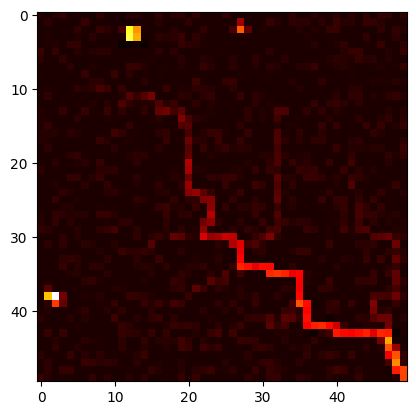

In [ ]:
import matplotlib.pyplot as plt

state_vals = torch.reshape(theta, (env.grid_size, env.grid_size))
plt.imshow(state_vals.cpu().numpy(), cmap="hot", interpolation="nearest")
plt.show()